In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy
import nfode

dt = 0.01
data = np.load('data_test.npz')
t_data = data['t_data']
x_data = data['x_data']

input_dim=2
output_dim=2
inner_dim=64
class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, inner_dim)
        self.fc2 = nn.Linear(inner_dim, inner_dim)
        self.fc3 = nn.Linear(inner_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = torch.load('model.pt')
x0 = x_data[:, 0]
x_preds = nfode.predict(model, t_data, x0)
loss = nn.MSELoss()
x_preds = torch.tensor(x_preds).requires_grad_(True)

/tmp/ipykernel_30782/3023775718.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pt')


0.0 %
0.22311468094600626 %
0.4462293618920125 %
0.6693440428380187 %
0.892458723784025 %
1.1155734047300312 %
1.3386880856760375 %
1.5618027666220438 %
1.78491744756805 %
2.0080321285140563 %
2.2311468094600624 %
2.454261490406069 %
2.677376171352075 %
2.900490852298081 %
3.1236055332440875 %
3.3467202141900936 %
3.5698348951361 %
3.792949576082106 %
4.016064257028113 %
4.239178937974119 %
4.462293618920125 %
4.685408299866131 %
4.908522980812138 %
5.131637661758144 %
5.35475234270415 %
5.577867023650156 %
5.800981704596162 %
6.024096385542169 %
6.247211066488175 %
6.470325747434181 %
6.693440428380187 %
6.916555109326194 %
7.1396697902722 %
7.362784471218206 %
7.585899152164212 %
7.809013833110218 %
8.032128514056225 %
8.255243195002231 %
8.478357875948237 %
8.701472556894243 %
8.92458723784025 %
9.147701918786256 %
9.370816599732262 %
9.59393128067827 %
9.817045961624276 %
10.040160642570282 %
10.263275323516288 %
10.486390004462294 %
10.7095046854083 %
10.932619366354306 %
11.15573

(array([3.97e+03, 1.55e+02, 5.90e+01, 3.30e+01, 2.80e+01, 8.00e+00,
        1.60e+01, 1.20e+01, 1.40e+01, 1.00e+01, 1.20e+01, 5.00e+00,
        9.00e+00, 4.00e+00, 7.00e+00, 6.00e+00, 2.00e+00, 9.00e+00,
        4.00e+00, 6.00e+00]),
 array([0.00000000e+00, 4.61727723e-05, 9.23455445e-05, 1.38518313e-04,
        1.84691089e-04, 2.30863865e-04, 2.77036626e-04, 3.23209417e-04,
        3.69382178e-04, 4.15554969e-04, 4.61727730e-04, 5.07900491e-04,
        5.54073253e-04, 6.00246072e-04, 6.46418834e-04, 6.92591595e-04,
        7.38764356e-04, 7.84937118e-04, 8.31109937e-04, 8.77282699e-04,
        9.23455460e-04]),
 <BarContainer object of 20 artists>)

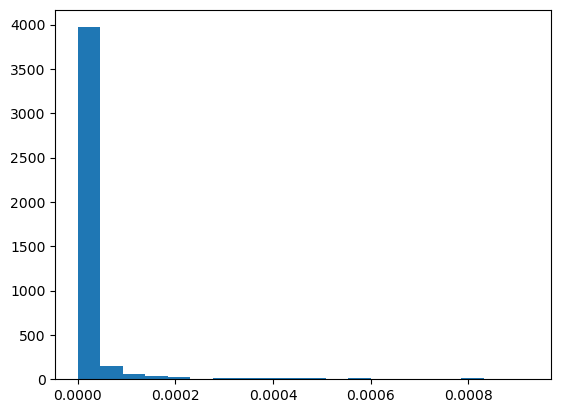

In [6]:
#本小节观察某个参数被扰动后模型输出的变化
params, flat_params, param_types, param_shapes = nfode.flatten_params(model)
l2 = []
for i in range(len(flat_params)):
    modified_params = copy.deepcopy(flat_params)
    if param_types[i] == 'weight':
        modified_params[i] = 0.05 + modified_params[i]
    else:
        modified_params[i] = 0.05 + modified_params[i]
    modified_model = nfode.update_model_params(model, modified_params, param_shapes)
    x_modified_preds = nfode.predict(modified_model, t_data, x0)
    x_modified_preds = torch.tensor(x_modified_preds).requires_grad_(True)
    #los = np.max(np.abs(x_preds - x_modified_preds))
    los = loss(x_preds, x_modified_preds).detach().numpy()
    l2.append(los)
    if i % 10 == 0:
        print(100 * i/len(flat_params), '%')

top_10_indices = np.argsort(l2)[-10:][::-1]  # 对l排序并取最大的10个索引
top_10_values = np.array([l2[i] for i in top_10_indices])
print(top_10_indices)
print(top_10_values)
upper_limit = np.percentile(l2, 97.5)
l2hist = [x for x in l2 if x <= upper_limit]
plt.hist(l2hist, bins=20)

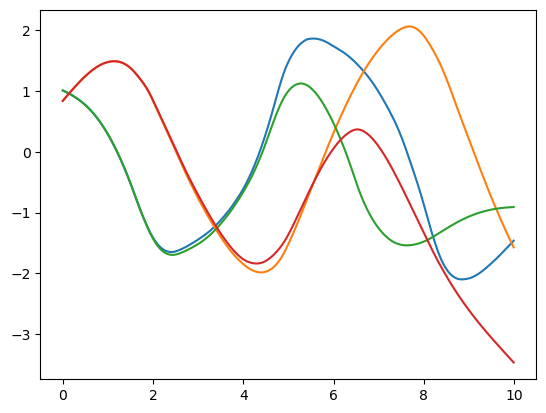

In [25]:
#本小节观察第i个被扰动后模型输出的变化
params, flat_params, param_types, param_shapes = nfode.flatten_params(model)
i = 66
d = 0.2
modified_params = copy.deepcopy(flat_params)
if param_types[i] == 'weight':
    modified_params[i] += d
else:
    modified_params[i] += d
modified_model = nfode.update_model_params(model, modified_params, param_shapes)
x_modified_preds = nfode.predict(modified_model, t_data, x_data.T, dt)
plt.plot(t_data, x_preds.detach().numpy())
plt.plot(t_data, x_modified_preds)


In [ ]:
#本小节观察某个参数被删去后模型输出的变化
params, flat_params, param_types, param_shapes = nfode.flatten_params(model)
l1 = []
for i in range(len(flat_params)):
    modified_params = copy.deepcopy(flat_params)
    if param_types[i] == 'weight':
        modified_params[i] = 1
    else:
        modified_params[i] = 0
    modified_model = nfode.update_model_params(model, modified_params, param_shapes)
    x_modified_preds = nfode.predict(modified_model, t_data, x_data.T, dt)
    x_modified_preds = torch.tensor(x_modified_preds).requires_grad_(True)
    #los = np.max(np.abs(x_preds - x_modified_preds))
    los = loss(x_preds, x_modified_preds).detach().numpy()
    l1.append(los)
    if i % 10 == 0:
        print(100 * i/len(flat_params), '%')

top_10_indices = np.argsort(l1)[-10:][::-1]  # 对l排序并取最大的10个索引
top_10_values = np.array([l1[i] for i in top_10_indices])
print(top_10_indices)
print(top_10_values)
upper_limit = np.percentile(l1, 97.5)
l1hist = [x for x in l1 if x <= upper_limit]
plt.hist(l1hist, bins=20)

0.0 %
0.4163197335553705 %
0.832639467110741 %
1.2489592006661117 %
1.665278934221482 %
2.0815986677768525 %
2.4979184013322233 %
2.9142381348875936 %
3.330557868442964 %
3.7468776019983348 %
4.163197335553705 %
4.579517069109076 %
4.995836802664447 %
5.4121565362198165 %
5.828476269775187 %
6.244796003330558 %
6.661115736885928 %
7.077435470441299 %
7.4937552039966695 %
7.91007493755204 %
8.32639467110741 %
8.742714404662781 %
9.159034138218152 %
9.575353871773522 %
9.991673605328893 %
10.407993338884262 %
10.824313072439633 %
11.240632805995004 %
11.656952539550375 %
12.073272273105745 %
12.489592006661116 %
12.905911740216487 %
13.322231473771856 %
13.738551207327227 %
14.154870940882597 %
14.571190674437968 %
14.987510407993339 %
15.40383014154871 %
15.82014987510408 %
16.23646960865945 %
16.65278934221482 %
17.069109075770193 %
17.485428809325562 %
17.90174854288093 %
18.318068276436303 %
18.734388009991672 %
19.150707743547045 %
19.567027477102414 %
19.983347210657787 %
20.399666

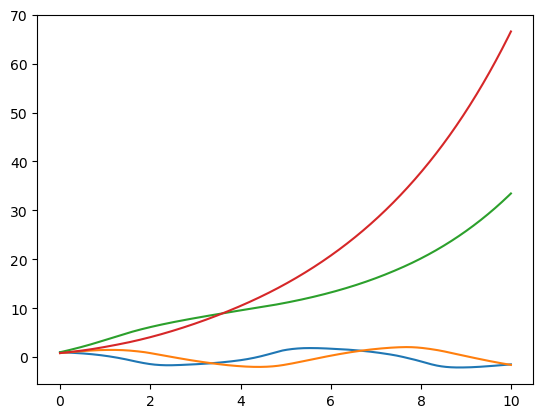

In [21]:
#本小节观察第i个被删去后模型输出的变化
params, flat_params, param_types, param_shapes = nfode.flatten_params(model)
i = 2343
modified_params = copy.deepcopy(flat_params)
if param_types[i] == 'weight':
    modified_params[i] = 1
else:
    modified_params[i] = 0
modified_model = nfode.update_model_params(model, modified_params, param_shapes)
x_modified_preds = nfode.predict(modified_model, t_data, x_data.T, dt)
plt.plot(t_data, x_preds.detach().numpy())
plt.plot(t_data, x_modified_preds)


In [33]:
indices = [index for index, value in enumerate(l1) if value < 0.01]
types = param_types[indices]

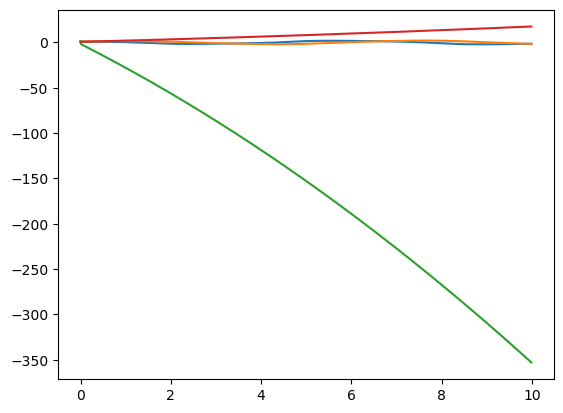

In [34]:
#本小节观察第i个被删去后模型输出的变化
params, flat_params, param_types, param_shapes = nfode.flatten_params(model)
modified_params = copy.deepcopy(flat_params)
for i in range(len(indices)):
    p = indices[i]
    if param_types[p] == 'weight':
        modified_params[i] = 1
    else:
        modified_params[i] = 0
modified_model = nfode.update_model_params(model, modified_params, param_shapes)
x_modified_preds = nfode.predict(modified_model, t_data, x_data.T, dt)
plt.plot(t_data, x_preds.detach().numpy())
plt.plot(t_data, x_modified_preds)